**Домашнее задание 4, выполнила Далия Гильманова**

## **Задание:**

1. Эксплоративный анализ (Распределение таргетов, топ-10 самых частых сущностей в каждом классе и т.д.) - 2 балла

2. Дообучить BERT (можно использовать и любой другой, главное, чтобы он был обучен заранее на этом датасете) и замерить качество на тестовом датасете - 4 балла
   
3. Дообучить BERT с помощью вашего любимого PEFT метода и сравнить качество с п.2. - 4 балла


**Приложенный датасет:**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! cp /content/drive/MyDrive/conll2003.zip dataset_hw4.zip

In [3]:
! unzip /content/dataset_hw4.zip

Archive:  /content/dataset_hw4.zip
   creating: conll2003/
  inflating: conll2003/train.tsv     
  inflating: __MACOSX/conll2003/._train.tsv  
  inflating: conll2003/test.tsv      
  inflating: __MACOSX/conll2003/._test.tsv  
  inflating: conll2003/valid.tsv     
  inflating: __MACOSX/conll2003/._valid.tsv  


**Посмотрим на датасет:**

In [4]:
! head -n 20 /content/conll2003/train.tsv

EU	B-ORG
rejects	O
German	B-MISC
call	O
to	O
boycott	O
British	B-MISC
lamb	O
.	O

Peter	B-PER
Blackburn	I-PER

BRUSSELS	B-LOC
1996-08-22	O

The	O
European	B-ORG
Commission	I-ORG
said	O


**Таким образом, у нас имеется датасет, где сэмплы разделены пустой строкой. Имеются лэйблы для конкретных значений, например, для организаций B-ORG или для личностей B-PER.**

## **Часть 1 Эксплоративный анализ**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
data = pd.read_csv('/content/conll2003/train.tsv', header=None, sep='\t')
data.columns = ['word', 'tag']
data.head(n=10)

,word,tag
0,EU,B-ORG
1,rejects,O
2,German,B-MISC
3,call,O
4,to,O
5,boycott,O
6,British,B-MISC
7,lamb,O
8,.,O
9,Peter,B-PER


**Распределение таргетов:**

In [ ]:
# посмотрим встречаемость каждого класса

list_flag_frequency  = data['tag'].value_counts().to_dict()

data['tag'].value_counts()

,count
tag,
O,101536
B-LOC,4687
B-PER,4533
B-ORG,4265
I-PER,3212
I-ORG,2307
B-MISC,2089
I-MISC,771
I-LOC,691


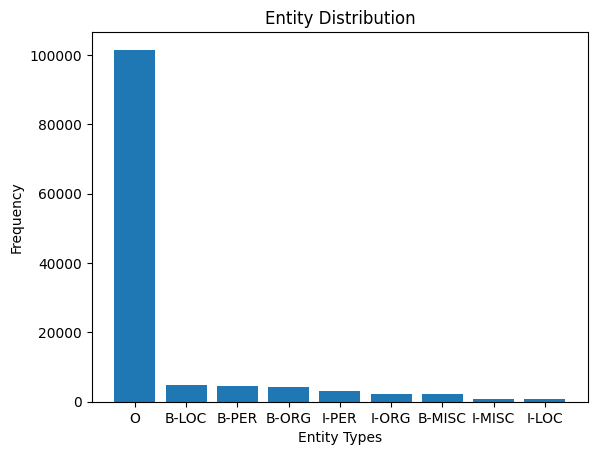

In [ ]:
# bar plot для распределения классов

import matplotlib.pyplot as plt

plt.bar(list(list_flag_frequency.keys()), list(list_flag_frequency.values()))
plt.title("Entity Distribution")
plt.xlabel("Entity Types")
plt.ylabel("Frequency")
plt.show()

**Больше всего, конечно, слов с тэгами, не относящимися к "интересным", то есть *О* (не является частью фразы). При этом самые частые - B-LOC, B-PER и B-ORG. I-TYPE значит, что слово находится внутри фразы типа TYPE**

In [ ]:
# посмотрим встречаемость каждого токена (до удаления стоп слов)

list_tokens_frequency = data['word'].value_counts().to_dict()

data['word'].value_counts().head(n=10)

,count
word,
.,4363
",",4284
the,4099
of,2166
(,2145
),2144
in,1967
to,1964
a,1799


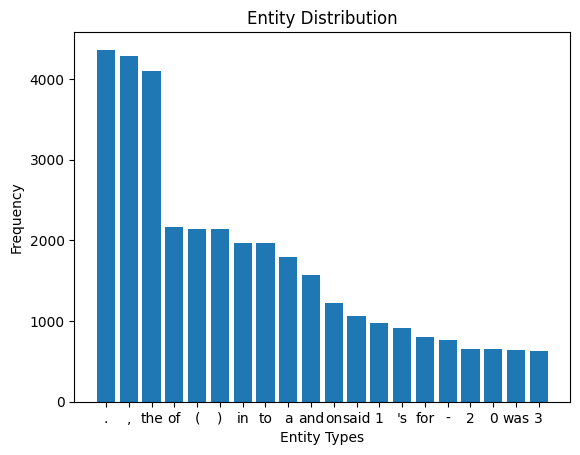

In [ ]:
# bar plot для распределения токенов

import matplotlib.pyplot as plt

plt.bar(list(list_tokens_frequency.keys())[:20], list(list_tokens_frequency.values())[:20])
plt.title("Entity Distribution")
plt.xlabel("Entity Types")
plt.ylabel("Frequency")
plt.show()

**Ну здесь до удаления пунктуации и стоп-слов находится, конечно, в основном "мусор".**

**Топ-10 самых частых сущностей в каждом классе (так как у нас присутствуют стоп-слова в датасете, сначала удалим их):**

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Также же удалим пунктуацию, цифры и некоторые буквы, которые у меня вылезали:**

In [ ]:
unnecessary = ['','1','2','3','4','5','6','7','8','9','10','0','s']

def top_words_by_class(data, n=10):
    data = data[(data['word'].str.strip() != '') & (data['word'].notna())] # попытка удалить пустые строки
    words_by_class = {}
    for tag in data['tag'].unique():
        words_in_class = data[data['tag'] == tag]['word'].tolist()
        # удалим стоп-слова
        filtered_words = [word for word in words_in_class if word not in stop_words and word not in unnecessary]
        translator = str.maketrans('', '', string.punctuation)
        filtered_words = [str(word).translate(translator) for word in filtered_words]
        word_counts = Counter(filtered_words)
        words_by_class[tag] = word_counts.most_common(n)
    return words_by_class

In [ ]:
top_words = top_words_by_class(data)
top_words

{'B-ORG': [('Reuters', 45),
  ('St', 35),
  ('UN', 28),
  ('FC', 28),
  ('NEW', 23),
  ('CHICAGO', 23),
  ('SAN', 21),
  ('Honda', 20),
  ('New', 19),
  ('European', 18)],
 'O': [('', 14956),
  ('said', 1059),
  ('s', 894),
  ('The', 596),
  ('DOCSTART', 592),
  ('first', 256),
  ('beat', 244),
  ('two', 209),
  ('would', 190),
  ('percent', 182)],
 'B-MISC': [('Russian', 59),
  ('German', 55),
  ('British', 49),
  ('French', 43),
  ('Australian', 39),
  ('American', 35),
  ('English', 33),
  ('US', 33),
  ('Olympic', 29),
  ('Dutch', 28)],
 'B-PER': [('Michael', 42),
  ('Mark', 40),
  ('Paul', 39),
  ('David', 37),
  ('Clinton', 36),
  ('John', 33),
  ('M', 29),
  ('Wasim', 27),
  ('Thomas', 26),
  ('Peter', 24)],
 'I-PER': [('Ahmed', 31),
  ('Akram', 26),
  ('Teresa', 20),
  ('Martin', 19),
  ('Khan', 18),
  ('Younis', 16),
  ('Sohail', 15),
  ('Anwar', 13),
  ('Clinton', 13),
  ('Sanchez', 12)],
 'B-LOC': [('US', 209),
  ('Germany', 112),
  ('Australia', 105),
  ('Britain', 104),
  

**Получилось достаточно интересно, самая частая локация - Соединенные штаты. Кроме того, не получилось удалить весь мусор из О класса, но надеюсь, это не страшно. Там изначально было много "мусора".**

**Что еще необоходимо в данном пункте не указано, но я построю word cloud нескольких для самых частых классов:**

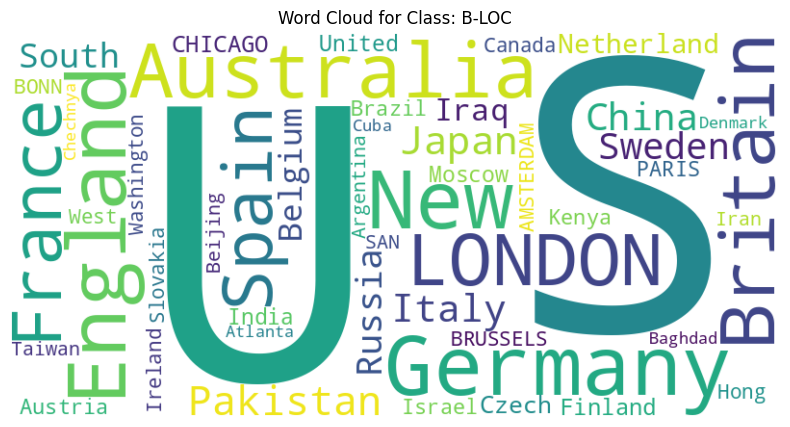

In [ ]:
from wordcloud import WordCloud, STOPWORDS

class_data = data[data['tag'] == 'B-LOC']
text = " ".join(class_data['word'].astype(str))
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
      width=800,
      height=400,
      background_color="white",
      stopwords=stopwords,
      max_words=50,
      colormap="viridis",
      collocations=False
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Word Cloud for Class: {'B-LOC'}")
plt.show()

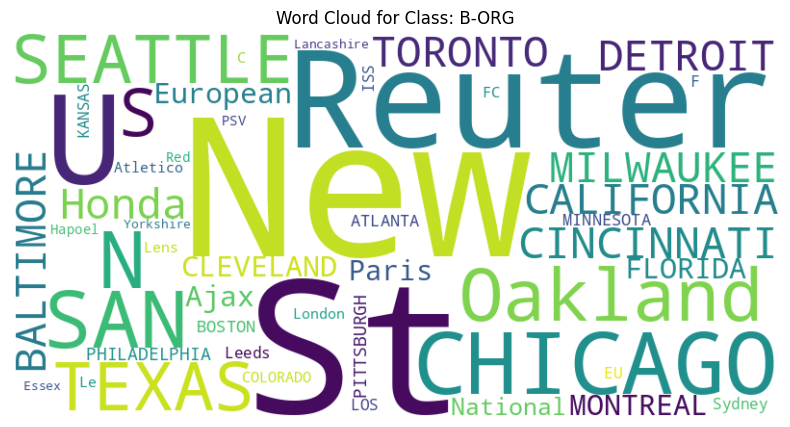

In [ ]:
class_data = data[data['tag'] == 'B-ORG']
text = " ".join(class_data['word'].astype(str))
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
      width=800,
      height=400,
      background_color="white",
      stopwords=stopwords,
      max_words=50,
      colormap="viridis",
      collocations=False
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Word Cloud for Class: {'B-ORG'}")
plt.show()

**В целом, для остальных аналогично. Далее я буду работать напрямую с файлами, чтобы составить правильный датафрейм.**

## **Часть 2 Дообучить BERT**

**Для данной части домашнего задания я нашла гайд на huggingface по токен-классификации, который мне очень помог с токенизацией данных и в обучении берта:**

https://huggingface.co/learn/nlp-course/en/chapter7/2#processing-the-data

In [6]:
%pip install --quiet transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 peft==0.5.0 bitsandbytes==0.41.2.post2

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from tqdm.auto import tqdm, trange

assert torch.cuda.is_available(), "you need cuda for this part"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

!pip install datasets
from datasets import Dataset, Sequence, ClassLabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 16.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 39.7 MB/s eta 

Сразу возьму токенизатор для "*distilbert-base-cased*" модели (подгружала таким образом, потому что если брать просто *DistilBertTokenizer*, то вылезает требование о фаст-токенизаторе, а для обучения нам необходимы модель и именно ее токенизатор):

In [7]:
from transformers import DistilBertModel, AutoTokenizer
#tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


**Для "энкодинга" лэйблов:**

In [8]:
label_names = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
label_map = {label: i for i, label in enumerate(label_names)}

**Далее было необходимо поделить входной файл по предложениям, которые разделены в файлах пустой строкой, чтобы далее работать с токенами для каждого отдельного предложения:**

In [9]:
def process_data_from_file(file_path):
    sentences_tokens = []
    sentences_tags = []
    current_sentence_tokens = []
    current_sentence_tags = []
    all_tokens = set()

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                if current_sentence_tokens:
                    sentences_tokens.append(current_sentence_tokens)
                    sentences_tags.append(current_sentence_tags)
                    current_sentence_tokens = []
                    current_sentence_tags = []
                continue

            parts = line.split()
            if len(parts) == 2:
                token, tag = parts
                current_sentence_tokens.append(token)
                current_sentence_tags.append(tag)
                all_tokens.add(token)

    if current_sentence_tokens:
        sentences_tokens.append(current_sentence_tokens)
        sentences_tags.append(current_sentence_tags)

    return sentences_tokens, sentences_tags, sorted(list(all_tokens))

**sentences_tokens - разделенные предложения, sentences_tags - соответствующие лэйблы**

In [10]:
sentences_tokens, sentences_tags, unique_tokens = process_data_from_file("/content/conll2003/train.tsv")

In [11]:
sentences_tags[0]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

**Ну и, конечно, добавляем численную информацию о лэйблах в переменную sentences_label_ids:**

In [12]:
sentences_label_ids = [[label_map[tag] for tag in sentence_tags] for sentence_tags in sentences_tags]
sentences_label_ids[0]

[3, 0, 7, 0, 0, 0, 7, 0, 0]

**Оборачиваем всё в общий датасет с помощью *Dataset.from_dict*:**

In [13]:
dataset_dict = {"tokens":sentences_tokens, "tags":sentences_tags, "label_ids":sentences_label_ids}
dataset = Dataset.from_dict(dataset_dict)

**Итоговый датасет для токенизации:**

In [14]:
dataset[0]

{'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'tags': ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'],
 'label_ids': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [15]:
print(dataset)
print(dataset.features)

Dataset({
    features: ['tokens', 'tags', 'label_ids'],
    num_rows: 14986
})
{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'tags': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'label_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


**Следующие две функции были взаимствованы из гайда, они помогли справиться с токенизацией. Таким образом, было проведено выравнивание лэйблов и токенизация:**

In [16]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [17]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["label_ids"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [18]:
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset.column_names,
)

Map:   0%|          | 0/14986 [00:00<?, ? examples/s]

**Итог токенизации (*tokenized_datasets* для тренировочного датасета):**

In [19]:
print(tokenized_datasets[0])
print(f"\nEncoded labels for the first example: {tokenized_datasets[0]['labels']}")

{'input_ids': [101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]}

Encoded labels for the first example: [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


In [20]:
print(tokenized_datasets[0]['input_ids'])

[101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102]


In [42]:
labels = tokenized_datasets["labels"]
#word_ids = tokenized_datasets[word_ids()]
print(labels[0])

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


**Ну и токенизируем для валидационного и тестового датасетов:**

In [21]:
sentences_tokens_val, sentences_tags_val, unique_tokens_val = process_data_from_file("/content/conll2003/valid.tsv")
sentences_label_ids_val = [[label_map[tag] for tag in sentences_tags_val] for sentences_tags_val in sentences_tags_val]

dataset_dict_val = {"tokens":sentences_tokens_val, "tags":sentences_tags_val, "label_ids":sentences_label_ids_val}
dataset_val = Dataset.from_dict(dataset_dict_val)

In [22]:
tokenized_datasets_val = dataset_val.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset_val.column_names,
)

Map:   0%|          | 0/3465 [00:00<?, ? examples/s]

In [23]:
sentences_tokens_test, sentences_tags_test, unique_tokens_test = process_data_from_file("/content/conll2003/test.tsv")
sentences_label_ids_test = [[label_map[tag] for tag in sentences_tags_test] for sentences_tags_test in sentences_tags_test]

dataset_dict_test = {"tokens":sentences_tokens_test, "tags":sentences_tags_test, "label_ids":sentences_label_ids_test}
dataset_test = Dataset.from_dict(dataset_dict_test)

In [24]:
tokenized_datasets_test = dataset_test.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset_test.column_names,
)

Map:   0%|          | 0/3683 [00:00<?, ? examples/s]

In [25]:
tokenized_datasets_val[1]

{'input_ids': [101, 149, 11414, 2137, 11414, 1820, 118, 4775, 118, 1476, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 5, 6, 6, 6, 0, 0, 0, 0, 0, -100]}

**Следующим шагом является Data collation (*набор правил, определяющих, как сравниваются и сортируются строковые данные, проще говоря, это способ определения порядка символов и строк*). Здесь же применяется DataCollatorForTokenClassification, так как должны быть дополнены не только inputs (input IDs, attention mask, and token type IDs), но и лэйблы:**

In [26]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [27]:
batch = data_collator([tokenized_datasets[i] for i in range(2)])
batch["labels"]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

In [28]:
for i in range(2):
    print(tokenized_datasets[i]["labels"])

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]
[-100, 1, 2, -100]


**Чтобы Trainer вычислял метрику каждую эпоху, нам потребуется определить функцию compute_metrics(), которая принимает массивы предсказаний и меток и возвращает словарь с названиями и значениями метрик. Также традиционным фреймворком, используемым для оценки предсказаний классификации токенов, является seqeval:**

In [29]:
!pip install seqeval
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=b485014b12ada7a14092df5ea93a708b1cebf82af11aaaa5bc36e57eda7645b9
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00


In [30]:
import evaluate

metric = evaluate.load("seqeval")

In [31]:
labels = dataset[0]["label_ids"]
labels = [label_names[i] for i in labels]
labels

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [ ]:
predictions = labels.copy()
predictions[2] = "O"
metric.compute(predictions=[predictions], references=[labels])

{'MISC': {'precision': 1.0,
  'recall': 0.5,
  'f1': 0.6666666666666666,
  'number': 2},
 'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 0.6666666666666666,
 'overall_f1': 0.8,
 'overall_accuracy': 0.8888888888888888}

**Метрики для оценки дообучения - precision, recall, f1, accuracy:**

In [32]:
import numpy as np


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

**Ну и наконец, выбираем модель из задания *distilbert/distilbert-base-cased*. Поскольку работа с задачей классификации токенов, то здесь используется класс AutoModelForTokenClassification. И также передать  информацию о количестве имеющихся у нас меток через словари отображений id2label и label2id:**

In [33]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [34]:
from transformers import AutoModelForTokenClassification

model_bert = AutoModelForTokenClassification.from_pretrained(
    "distilbert/distilbert-base-cased",
    id2label=id2label,
    label2id=label2id,
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_bert

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

In [ ]:
model_bert.config.num_labels

9

**И теперь дообучение модели через training. Количество эпох взяла равным 6:**

In [39]:
from transformers import TrainingArguments

args = TrainingArguments(
    "distilbert/distilbert-base-cased",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    load_best_model_at_end=True
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model_bert,
    args=args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets_val,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.245000,0.088327,0.871454,0.904746,0.887788,0.973766
2,0.059700,0.069818,0.910140,0.928980,0.919464,0.980951
3,0.033300,0.066663,0.905366,0.937058,0.920939,0.982420
4,0.021300,0.071762,0.914642,0.937731,0.926043,0.983298
5,0.012200,0.076521,0.914225,0.939919,0.926894,0.983572
6,0.008200,0.079924,0.916667,0.940424,0.928393,0.983615


/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location="cp

TrainOutput(global_step=5622, training_loss=0.051378157778339255, metrics={'train_runtime': 602.4844, 'train_samples_per_second': 149.242, 'train_steps_per_second': 9.331, 'total_flos': 1110357580652460.0, 'train_loss': 0.051378157778339255, 'epoch': 6.0})

In [ ]:
eval_metrics = trainer.evaluate(eval_dataset=tokenized_datasets_val)
print("Validation Metrics:", eval_metrics)

Validation Metrics: {'eval_loss': 0.06666254997253418, 'eval_precision': 0.9053658536585366, 'eval_recall': 0.9370582295523393, 'eval_f1': 0.9209394641085016, 'eval_accuracy': 0.982419765884843, 'eval_runtime': 7.0597, 'eval_samples_per_second': 490.814, 'eval_steps_per_second': 30.738, 'epoch': 6.0}


**Сохранились результаты после 3 эпохи!**

**На тесте:**

In [ ]:
predictions = trainer.predict(tokenized_datasets_test)
test_metrics = predictions.metrics

print("Test Metrics:", test_metrics)

Test Metrics: {'test_loss': 0.1664189249277115, 'test_precision': 0.8494479759116762, 'test_recall': 0.8990793201133145, 'test_f1': 0.87355926371925, 'test_accuracy': 0.9679888122204976, 'test_runtime': 6.3817, 'test_samples_per_second': 577.116, 'test_steps_per_second': 36.197}


**Я выбрала 6 эпох для обучения, но лосс на валидации впоследствии начал увеличиваться, возможно стоило уменьшить количество эпох или чуть поменять параметры обучения. При этом метрики получить хорошие, особенно *accuracy* (на тесте 0,967), хотя у *precision* значение равно чуть меньше 0,849. Само обучение заняло всего 3 эпохи, дальше значения начали падать.**

## **Часть 3 Дообучить BERT с помощью PEFT**

In [35]:
!pip install peft
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

**Модель и токенизатор (и токенизированные датасеты) у нас есть. Но всё равно пропишу здесь код для модели:**

In [ ]:
from transformers import AutoModelForTokenClassification

model_peft = AutoModelForTokenClassification.from_pretrained(
    "distilbert/distilbert-base-cased",
    id2label=id2label,
    label2id=label2id,
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Параметры LoRA:**

In [36]:
peft_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS, # задача классификации токенов
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=['q_lin', 'k_lin', 'v_lin', 'out_lin']
)

**Ну и подгрузка конфигурации пефт к начальной модели:**

In [37]:
peft_model = get_peft_model(model_peft, peft_config)
peft_model.print_trainable_parameters()

trainable params: 308,754 || all params: 65,499,666 || trainable%: 0.47138255636295917


**Используем те же параметры для обучения, что и до этого:**

In [40]:
peft_args = TrainingArguments(
    "distilbert/distilbert-base-cased",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    load_best_model_at_end=True
)

In [41]:
from transformers import Trainer

trainer = Trainer(
    model=peft_model,
    args=peft_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets_val,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.912200,0.374452,0.403000,0.479300,0.437851,0.901099
2,0.294100,0.236705,0.580383,0.662235,0.618613,0.929780
3,0.221000,0.205041,0.628446,0.721306,0.671682,0.938073
4,0.201600,0.185912,0.668423,0.747391,0.705705,0.945172
5,0.185800,0.178833,0.670643,0.756984,0.711202,0.946367
6,0.179700,0.175334,0.684713,0.759845,0.720325,0.947893


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapters_weights = torch.load(filename, map_location=t

TrainOutput(global_step=5622, training_loss=0.2955304081013346, metrics={'train_runtime': 520.675, 'train_samples_per_second': 172.691, 'train_steps_per_second': 10.798, 'total_flos': 1118236671541080.0, 'train_loss': 0.2955304081013346, 'epoch': 6.0})

**Дообучим еще, так как видно, что эпох не хватило. Ниже представлен уже второй запуск представленной ниже ячейки:**

In [ ]:
trainer = Trainer(
    model=peft_model,
    args=peft_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets_val,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.136100,0.126829,0.781137,0.834904,0.807126,0.962478
2,0.127400,0.122708,0.778035,0.848872,0.811911,0.962925
3,0.120700,0.119448,0.791582,0.854594,0.821882,0.964163
4,0.119600,0.115520,0.808143,0.858465,0.832544,0.966063
5,0.117400,0.115586,0.803857,0.862841,0.832305,0.965444
6,0.114000,0.112955,0.808847,0.861663,0.834420,0.966107


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapters_weights = torch.load(filename, map_location=t

TrainOutput(global_step=5622, training_loss=0.1231181583384185, metrics={'train_runtime': 419.9327, 'train_samples_per_second': 214.12, 'train_steps_per_second': 13.388, 'total_flos': 1118236671541080.0, 'train_loss': 0.1231181583384185, 'epoch': 6.0})

**Посмотрим на текущим результат на тестовых данных:**

In [ ]:
predictions = trainer.predict(tokenized_datasets_test)
pred_logits = predictions.predictions
true_labels = predictions.label_ids
test_metrics = predictions.metrics

print("Test Metrics:", test_metrics)

Test Metrics: {'test_loss': 0.15782126784324646, 'test_precision': 0.7714378871861755, 'test_recall': 0.8378186968838527, 'test_f1': 0.8032592089628248, 'test_accuracy': 0.9550337323846261, 'test_runtime': 11.8555, 'test_samples_per_second': 310.658, 'test_steps_per_second': 19.485}


**Ну и попробуем дообучить еще:**

In [ ]:
trainer = Trainer(
    model=peft_model,
    args=peft_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets_val,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.114400,0.111058,0.818254,0.863009,0.840036,0.966956
2,0.107900,0.108673,0.809509,0.871087,0.839170,0.966711
3,0.102900,0.106475,0.816839,0.875126,0.844979,0.967978
4,0.102600,0.104764,0.826743,0.876136,0.850723,0.968943
5,0.102100,0.104645,0.821991,0.878156,0.849146,0.968857
6,0.099000,0.102350,0.829990,0.877482,0.853076,0.969173


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapters_weights = torch.load(filename, map_location=t

TrainOutput(global_step=5622, training_loss=0.10520598117417179, metrics={'train_runtime': 440.9709, 'train_samples_per_second': 203.905, 'train_steps_per_second': 12.749, 'total_flos': 1118236671541080.0, 'train_loss': 0.10520598117417179, 'epoch': 6.0})

**ИТОГ НА ТЕСТОВЫХ без PEFT:**

In [ ]:
predictions = trainer.predict(tokenized_datasets_test)
pred_logits = predictions.predictions
true_labels = predictions.label_ids
test_metrics = predictions.metrics

print("Test Metrics:", test_metrics)

Test Metrics: {'test_loss': 0.15454591810703278, 'test_precision': 0.7892229341218991, 'test_recall': 0.8505665722379604, 'test_f1': 0.8187473370259907, 'test_accuracy': 0.9578767807471839, 'test_runtime': 7.2271, 'test_samples_per_second': 509.608, 'test_steps_per_second': 31.963}


**Конечно, с пефтом модель дообучилась стабильнее и метрики в конечном итоге хорошие, но понадобилось сильно больше эпох для обучения, чем обучению без пефта.**

**Тем не менее, лосс здесь выше и, как уже упоминалось, для обучения потребовалось около 20+ эпох, даже так не достигнув результата recall=0,89 и accuracy=0,97 на тестовых, а модель без PEFT почти сразу показывала такие высокие метрики (спустя 3 эпохи).**

**Без PEFT (для сравнения):**

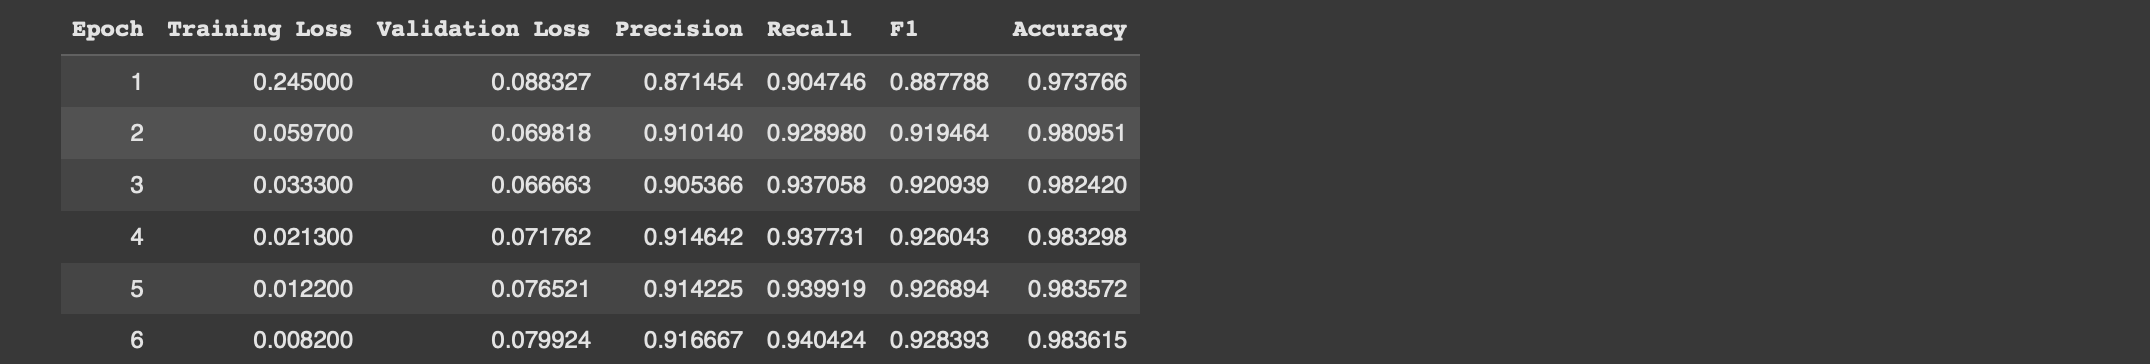

**Думаю, дообучились оба варианта достаточно хорошо, но при таком раскладе я бы больше доверяла больше обучению без пефта.**

## Бонус

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model
tokenizer_gpt = GPT2Tokenizer.from_pretrained('gpt2')
model_gpt = GPT2Model.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
class GPT2ForTokenClassification(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.gpt2 = GPT2Model.from_pretrained(model_name)
        self.dropout = nn.Dropout(self.gpt2.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.gpt2.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.gpt2(input_ids, attention_mask=attention_mask, return_dict=True)
        sequence_output = outputs.last_hidden_state
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            # Only consider tokens with label != -100 to avoid calculating loss on padding tokens
            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, self.classifier.out_features)
            active_labels = torch.where(
                active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
            )
            loss = loss_fct(active_logits, active_labels)

        return {"loss": loss, "logits": logits}

# 2. Prepare Your Dataset
class TokenClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, label_map):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.label_map = label_map

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        words = text.split()
        label_ids = [self.label_map[label] for label in self.labels[idx]]

        encoding = self.tokenizer(
            words,
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=128,  # Adjust as needed
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Align labels with tokens
        word_ids = encoding.word_ids()
        aligned_labels = [-100] * len(word_ids) # Initialize with ignore index
        label_idx = 0
        for i, word_idx in enumerate(word_ids):
            if word_idx is not None and word_idx < len(label_ids):
                if word_ids[i-1] != word_idx: # Only label the first subword of each word
                    aligned_labels[i] = label_ids[word_idx]

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(aligned_labels)
        }

# 3. Define Training Parameters
model_name = 'gpt2'
tokenizer_gpt = GPT2TokenizerFast.from_pretrained(model_name)
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token # Important for padding
num_labels = 5  # Replace with the actual number of your labels
label_map = {"O": 0, "B-LOC": 1, "I-LOC": 2, "B-ORG": 3, "I-ORG": 4} # Example label map
id_to_label = {v: k for k, v in label_map.items()}

# Example Data (replace with your actual data)
texts = ["The quick brown fox jumps over the lazy dog .", "New York is a big city ."]
labels_str = [["O", "O", "O", "O", "O", "O", "O", "O", "O", "O"], ["B-LOC", "I-LOC", "O", "O", "O", "O", "O"]]

# 4. Create Dataset and DataLoader
dataset = TokenClassificationDataset(texts, labels_str, tokenizer_gpt, label_map)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 5. Initialize Model, Optimizer
model = GPT2ForTokenClassification(model_name, num_labels)
optimizer = AdamW(model.parameters(), lr=5e-5)

# 6. Training Loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.train()

num_epochs = 3
for epoch in range(num_epochs):
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optimizer.step()

        # Print training loss (optional)
        print(f"Loss: {loss.item()}")

# 7. Evaluation (Optional)
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs['logits']
        predictions = torch.argmax(logits, dim=-1).cpu().tolist()
        true_labels = labels.cpu().tolist()

        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)

# Process predictions and true labels to remove -100 and map to original labels
filtered_predictions = [[id_to_label[p] for p, l in zip(pred_seq, label_seq) if l != -100]
                        for pred_seq, label_seq in zip(all_predictions, all_true_labels)]
filtered_true_labels = [[id_to_label[l] for l in label_seq if l != -100]
                         for label_seq in all_true_labels]

# You can now use metrics like accuracy, precision, recall, F1-score to evaluate
# Example using sklearn.metrics
from sklearn.metrics import accuracy_score

flat_predictions = [p for sublist in filtered_predictions for p in sublist]
flat_true_labels = [l for sublist in filtered_true_labels for l in sublist]

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(f"Accuracy: {accuracy}")

# 8. Save the Model
model_path = "gpt2-token-classification-model"
model.save_pretrained(model_path)
tokenizer_gpt.save_pretrained(model_path)